# Prédiction de types MBTI à partir de Tweets

Ce notebook étend le travail réalisé sur le dataset Kaggle MBTI. L'objectif est de voir s'il est possible de prédire le type MBTI de célébrités à partir de leurs Tweets.

Pour cela, nous avons récupéré les 50 derniers Tweets de **77 célébrités** dont nous avons obtenu le type MBTI grâce à [The MBTI Database](https://www.mbtidatabase.com/).

Commençons par importer les librairies pertinentes :

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns

pd.set_option('display.width', 3000)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

Import des données :

In [2]:
DATASET = "./data/tweets.json"

def get_dataset():
    data = pd.read_json(DATASET, orient='records')
    data = data[["text", "mbti", "name", "screen_name"]]
    return data

In [3]:
data = get_dataset()

Aperçu du dataset :

In [4]:
data.head()

,text,mbti,name,screen_name
0,"From a big NBA fan, congrats to future Hall of...",ENFJ,Barack Obama,BarackObama
1,A voice everybody should hear. https://t.co/0u...,ENFJ,Barack Obama,BarackObama
2,And here are some ways to help cyclone victims...,ENFJ,Barack Obama,BarackObama
3,"What a great moment. Happy 110th, Virginia. ht...",ENFJ,Barack Obama,BarackObama
4,Michelle and I send our deepest sympathies to ...,ENFJ,Barack Obama,BarackObama


Nombre de tweets récupérés :

In [5]:
len(data)

2789

## Analyse du dataset

Tout d'abord, regardons la répartition des types MBTI au sein des tweets récupérés :

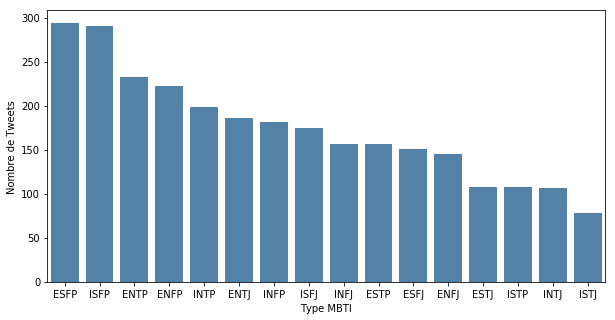

In [6]:
# Comptage des types MBTI
counts = data.mbti.value_counts()
mbti_types = counts.index
num_users = counts.values

# Tracé du graphique
plt.figure(figsize=(10,5))
sns.barplot(mbti_types, num_users, color="steelblue")
plt.xlabel("Type MBTI")
plt.ylabel("Nombre de Tweets");

La répartition est plus uniforme que sur le dataset Kaggle MBTI. C'est une conséquence du fait que l'on a choisi les personnalités pour équilibrer le nombre d'utilisateurs par type MBTI.

Par contre, les types MBTI dominants sont très différents : dans ce dataset, ESFP et ISFP sont dominants alors qu'ils étaient minoritaires dans le dataset Kaggle MBTI.

## Apprentissage supervisé

On entraîne un classificateur de type régression logistique sur la base de données de tweets. Ce classificateur a été choisi car c'est celui qui a donné les meilleurs résultats sur le dataset Kaggle MBTI.

In [7]:
# TODO: fusionner avec preprocessing.py

from sklearn.metrics import confusion_matrix

NUM_CLASSES = 16

def evaluate(y, predicted_y):
    """Evaluation de prédictions par rapport aux types MBTI attendues.
    
    Le calcul de la précision et du rappel se fait par moyennage sur chaque type MBTI.
    """
    cm = pd.DataFrame(confusion_matrix(y, predicted_y))

    precision = np.int32(0)
    for mbti in range(NUM_CLASSES):
        try:
            precision += np.int32(cm[mbti][mbti]) / np.sum([cm[i][mbti] for i in range(NUM_CLASSES)])
        except RuntimeWarning:
            pass

    precision /= NUM_CLASSES

    recall = np.int32(0)
    for mbti in range(NUM_CLASSES):
        try:
            recall += np.int32(cm[mbti][mbti]) / np.sum([cm[mbti][j] for j in range(NUM_CLASSES)])
        except RuntimeWarning:
            pass
    recall /= NUM_CLASSES

    f_score = 2 * precision * recall / (precision + recall) if precision > 0 and recall > 0 else 0

    return pd.DataFrame([{"precision": precision, "recall": recall, "f_score": f_score}])

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from preprocessing import format_text

X = data.text  # Inputs
Y = data.mbti  # Outputs (labels)

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.4)

# Vectorisation du texte.
vectorizer = CountVectorizer(stop_words="english")
train_x = vectorizer.fit_transform(train_x.apply(format_text))
test_x = vectorizer.transform(test_x.apply(format_text))

# Définition et entraînement du classificateur.
clf = LogisticRegression(class_weight="balanced")
clf.fit(train_x, train_y)

# Calcul des scores.
train_score = clf.score(train_x, train_y)
test_score = clf.score(test_x, test_y)

# Calcul et évaluation des résultats.
y = clf.predict(test_x)
res = evaluate(test_y, y)

res

,f_score,precision,recall
0,0.326443,0.305911,0.349929


## Analyse des résultats

Sur le dataset Kaggle MBTI, on obtenait un f-score de près de 0.8; il est ici d'environ 0.33. Les performances sont donc bien moindres.

Le comportement en généralisation pourrait également être meilleur. Par exemple, les tweets suivants ont été publiés par un ENFJ :

In [14]:
tweets = [
    "Hey all, anyone aware of some really good material to get started with @vuejs in the real world, transitioning from Angular? 😄 Basics (boilerplate, components, API interaction), useful tooling (VueCLI, TS?), best practices... Any insight very helpful. 🙏 Thanks!",
    "Thrilled to say — UPDATE RELEASED! ✨ Hope you enjoy all the new features! I had fun implementing them. Feedback much appreciated."
]
x = vectorizer.transform(np.array([format_text(t) for t in tweets]))
clf.predict(x)

array(['ISFP', 'ENTP'], dtype=object)

La moindre qualité des prédictions peut s'expliquer de plusieurs manières.

Il est fort possible que le type MBTI des personnes ne transparaisse pas dans les Tweets, pour plusieurs raisons :

- Le texte d'un Tweet est influencé par un grand nombre de facteurs, ne serait-ce que la longueur limitée du texte.
- Les personnes n'écrivent pas forcément d'une façon qui reflète leur personnalité étant donné que Twitter est surtout utilisé à des fins de communication.
- Les utilisateurs Twitter ont plus tendance à porter un "masque" que sur un espace plus intimiste tel que le forum PersonalityCafe.

Il y a aussi probablement d'autres caractéristiques que le texte qui font transparaître la personnalité d'un utilisateur sur Twitter : usage de la ponctuation, des emojis, etc.

Il est aussi probable que choisir les 50 derniers tweets ne suffise pas à évaluer la personnalité d'un utilisateur Twitter.

Ce travail constituait une tentative de transposition du travail effectué sur le dataset Kaggle MBTI, mais il apparaît finalement évident qu'une analyse plus approfondie de la morphologie et de la structure des données de type Tweets soit nécessaire. De futurs travaux pourront probablement s'inspirer de travaux de recherche sur le comportement des utilisateurs sur les réseaux sociaux comme Twitter.